In [1]:
import math
import numpy as np
from numpy.random import default_rng

import scipy
from scipy.stats import qmc
from smt.sampling_methods import LHS

from sklearn.metrics import mean_squared_error

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import gpytorch
from sklearn.decomposition import PCA

import time
import os
os.makedirs("fig/0/", exist_ok=True)
os.makedirs("data/0/", exist_ok=True)

%matplotlib inline 
font = {'size'   : 30}
matplotlib.rc('font', **font)
cbformat = matplotlib.ticker.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2))
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
torch.set_default_dtype(torch.double)
torch.set_default_device(device)
torch.set_printoptions(precision=10)

In [2]:
def f(x):
    """
    Vectorized piecewise cosine function.
    Args:
        x (torch.Tensor): Tensor of shape (N, 1) with values in [0, 1]
    Returns:
        torch.Tensor: Same shape as x
    """
    y = torch.full_like(x, 1.35)
    y[x <= 0.33] *= torch.cos(12 * torch.pi * x[x <= 0.33])
    y[x >= 0.66] *= torch.cos(6 * torch.pi * x[x >= 0.66])
    return y

In [3]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dims=[6,],
                 activation=nn.LogSigmoid, activation_kwargs=None):
        super().__init__()
        if activation_kwargs is None:
            activation_kwargs = {}
        act = lambda: activation(**activation_kwargs)

        # ----- Encoder -----
        encoder_layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, h))
            encoder_layers.append(nn.BatchNorm1d(h,affine=False))
            encoder_layers.append(act())
            prev_dim = h
        encoder_layers.append(nn.Linear(prev_dim, latent_dim))  # Final layer to latent
        encoder_layers.append(nn.BatchNorm1d(latent_dim,affine=False))
        encoder_layers.append(act())
        self.encoder_net = nn.Sequential(*encoder_layers)

        # ----- Decoder -----
        decoder_layers = []
        prev_dim = latent_dim
        for h in reversed(hidden_dims):
            decoder_layers.append(nn.Linear(prev_dim, h))
            decoder_layers.append(act())
            prev_dim = h
        decoder_layers.append(nn.Linear(prev_dim, input_dim))  # Final output
        self.decoder_net = nn.Sequential(*decoder_layers)

    def encode(self, x):
        return self.encoder_net(x)

    def decode(self, z):
        return self.decoder_net(z)

    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat, z

    def ae_loss(self, x, lambda_l2_z=0., lambda_l2_param=0.):
        """
        AE loss with optional latent L2 and parameter L2 regularization
    
        Args:
            x: input tensor
            lambda_l2_z: regularization on latent code z (default 1e-3)
            lambda_l2_param: explicit L2 on model parameters (default 1e-3)
    
        Returns:
            total_loss, recon_loss, latent_l2, param_l2
        """
        x_hat, z = self.forward(x)
        recon_loss = F.mse_loss(x_hat, x, reduction='mean')
    
        # --- Latent code regularization ---
        latent_l2 = torch.mean(z.pow(2)) if lambda_l2_z > 0 else torch.tensor(0., device=x.device)
    
        # --- Explicit parameter regularization ---
        param_l2 = torch.tensor(0., device=x.device)
        if lambda_l2_param > 0:
            for param in self.parameters():
                if param.requires_grad:
                    param_l2 += torch.sum(param.pow(2))
    
        total_loss = recon_loss + lambda_l2_z * latent_l2 + lambda_l2_param * param_l2
        return total_loss, recon_loss, latent_l2, param_l2

In [4]:
class ParametricGP(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.log_lengthscale = nn.Parameter(torch.zeros(latent_dim))  # θ_l
        self.log_eta = nn.Parameter(torch.tensor(-2.0))                # log η
        self._last_tau2_hat = 0.0

    def kernel(self, x1, x2):
        """
        Gaussian RBF kernel with ARD (SE-ARD), scaled by tau².
        """
        lengthscale = torch.exp(self.log_lengthscale)
        x1_ = x1 / lengthscale
        x2_ = x2 / lengthscale
        dist_sq = torch.cdist(x1_, x2_, p=2).pow(2)
        return torch.exp(-0.5 * dist_sq)  # base kernel k(x,x')

    def compute_K_eta(self, x):
        """
        Return K + ηI (without τ²), to be scaled externally.
        """
        K = self.kernel(x, x)
        eta = torch.exp(self.log_eta)
        N = x.size(0)
        return K + eta * torch.eye(N, device=x.device)

    def predict(self, x_train, y_train, x_test):
        """
        GP posterior mean and variance following Eqn (2.2) from your paper.
        """
        K_eta = self.compute_K_eta(x_train)
        k_star = self.kernel(x_train, x_test)
        k_ss_diag = torch.ones(x_test.size(0), device=x_test.device)  # since k(x,x)=1

        L = torch.linalg.cholesky(K_eta + 1e-6 * torch.eye(K_eta.shape[0], device=K_eta.device))
        alpha = torch.cholesky_solve(y_train, L)

        # Estimate τ² from data
        N = y_train.shape[0]
        tau2_hat = ((y_train.T @ alpha) / N).squeeze().detach()
        self._last_tau2_hat = tau2_hat.item()

        mean = k_star.T @ alpha                                 # (M, 1)
        v = torch.cholesky_solve(k_star, L)
        k_star_Kinv_k_star = (k_star.T @ v).diagonal().unsqueeze(-1)
        eta = torch.exp(self.log_eta)

        var = tau2_hat * (1 + eta - k_star_Kinv_k_star)         # (M, 1)
        return mean, var

    def log_marginal_likelihood(self, x_train, y_train):
        """
        Profiled log-likelihood over η, using τ² = yᵀ K⁻¹ y / N
        """
        K_eta = self.compute_K_eta(x_train)
        L = torch.linalg.cholesky(K_eta + 1e-6 * torch.eye(K_eta.shape[0], device=K_eta.device))
        alpha = torch.cholesky_solve(y_train, L)

        N = y_train.shape[0]
        tau2_hat = ((y_train.T @ alpha) / N).squeeze().detach()
        self._last_tau2_hat = tau2_hat.item()

        term1 = y_train.T @ alpha
        term2 = torch.logdet(K_eta)
        return -(term1 + term2).squeeze()

    def get_hyperparams(self):
        return {
            "lengthscale": torch.exp(self.log_lengthscale).detach(),
            "eta": torch.exp(self.log_eta).item(),
            "tau²_hat": self._last_tau2_hat
        }

In [5]:
class JointModel(nn.Module):
    def __init__(self, ae, gp):
        """
        ae: Autoencoder model (with .encode(x): (N, d))
        gp: ParametricGP model (with .predict and .log_marginal_likelihood)
        """
        super().__init__()
        self.ae = ae
        self.gp = gp

    def forward(self, x_train, y_train, x_test):
        """
        Run AE + GP prediction pipeline

        Args:
            x_train: (N, D) input data
            y_train: (N, 1) target values
            x_test:  (M, D) test input data

        Returns:
            y_pred: mean predictions (M, 1)
            y_var:  predictive variances (M, 1)
        """
        z_train = self.ae.encode(x_train)  # (N, d)
        z_test = self.ae.encode(x_test)    # (M, d)
        return self.gp.predict(z_train, y_train, z_test)

    def loss(self, x, y):
        """
        Loss function: AE reconstruction + GP negative log marginal likelihood

        Args:
            x: (N, D)
            y: (N, 1)

        Returns:
            total_loss:  scalar
            ae_loss:     scalar
            gp_nll:      scalar
        """
        # Autoencoder loss
        ae_total, ae_recon, _, _ = self.ae.ae_loss(x)

        # GP negative log marginal likelihood
        z = self.ae.encode(x)
        gp_nll = -self.gp.log_marginal_likelihood(z, y)  # (maximize log-likelihood = minimize -ll)

        # Combined loss
        total_loss = ae_total + gp_nll
        #return total_loss, ae_total, gp_nll
        return total_loss, ae_total, gp_nll

In [6]:
def generate_dataset_for_al_gp(
    N_train=10,
    N_test=500,
    N_ref=100,
    N_cand=100,
    bounds = [0.0, 1.0],
    noise_scale=0.1,
    device="cpu",
    seed=None,
):
    """
    Generate all necessary sets for active learning GP on Heaviside function.
    
    Returns:
        x_train, y_train
        x_test, y_test
        x_ref, y_ref
        x_cand, y_cand
        y_mean, y_std (used if standardization applied)
    """
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
        
    def lhs_sample(N, bounds):
        lhs = LHS(xlimits=np.array([bounds]))
        lhs = np.sort(lhs(N),axis=0)
        return torch.tensor(lhs, dtype=torch.float64, device=device)

    # --- 1. Training set ---
    x_train = lhs_sample(N_train, bounds)
    y_clean_train = f(x_train)
    y_train = y_clean_train + torch.randn_like(y_clean_train) * noise_scale

    # --- 2. Test set (LHS in [-5, 5]) ---
    x_test = lhs_sample(N_test, bounds)
    y_clean_test = f(x_test)
    y_test = y_clean_test + torch.randn_like(y_clean_test) * noise_scale

    # --- 3. Reference set (LHS in [-2, 2]) ---
    x_ref = lhs_sample(N_ref, [0.0, 1.0])
    y_ref = f(x_ref) # 

    # --- 4. Candidate set (LHS in [-2, 2]) ---
    x_cand = lhs_sample(N_cand, [0.0, 1.0])
    y_clean_cand = f(x_cand)
    y_cand = y_clean_cand + torch.randn_like(y_clean_cand) * noise_scale

    return x_train, y_train, x_test, y_test, x_ref, y_ref, x_cand, y_cand

In [7]:
def train_joint(
    model, x_train, y_train,
    max_outer_iter=5000,
    max_inner_iter=20,
    tol_loss_change_pct=1e-4,
    verbose=False,
):
    """
    Train a JointModel using L-BFGS with outer loop and early stopping.

    Args:
        model: JointModel instance
        x_train: (N, D)
        y_train: (N, 1)
        max_outer_iter: number of outer optimization steps
        max_inner_iter: L-BFGS inner max_iter
        tol_loss_change_pct: relative loss change to early stop
        verbose: whether to print log

    Returns:
        loss_history: list of total loss per outer iteration
    """
    loss_history = []

    optimizer = torch.optim.LBFGS(
        model.parameters(),
        lr=0.001,
        history_size=20,
        max_iter=max_inner_iter,
        line_search_fn="strong_wolfe"
    )

    for outer_epoch in range(max_outer_iter):
        def closure():
            optimizer.zero_grad()
            total_loss, ae_loss, gp_nll = model.loss(x_train, y_train)
            total_loss.backward()
            if verbose:
                print(f"[Epoch {outer_epoch:03d}] Total: {total_loss.item():.5f} | AE: {ae_loss.item():.5f} | GP-NLL: {gp_nll.item():.5f}")
            return total_loss

        optimizer.step(closure)

        # Compute current loss for stopping check
        with torch.no_grad():
            current_loss, _, _ = model.loss(x_train, y_train)
            loss_history.append(current_loss.item())

        # Early stopping check
        if len(loss_history) >= 2:
            numer = abs(loss_history[-1] - loss_history[-2])
            denom = abs(loss_history[-1] - loss_history[0]) + 1e-6
            rel_change = numer / denom
            if rel_change < tol_loss_change_pct:
                if verbose:
                    print(f"[Stopping] Relative loss change {rel_change:.2e} < tol {tol_loss_change_pct}")
                break
    return loss_history

In [8]:
def alc_acquisition(model, x_train, y_train, x_cand, x_ref, k_variance=10):
    """
    Two-stage ALC acquisition:
    1. From all candidates, pick top-k_variance with highest posterior variance.
    2. Among these, compute exact ALC (Cohn style) and select best one.
    """
    model.gp.eval()
    model.ae.eval()

    N, Nc, Nr = x_train.shape[0], x_cand.shape[0], x_ref.shape[0]
    device = x_train.device

    with torch.no_grad():
        # Encode inputs
        z_train = model.ae.encode(x_train)
        z_cand = model.ae.encode(x_cand)
        z_ref = model.ae.encode(x_ref)

        # GP kernel and posterior variance
        K = model.gp.compute_K_eta(z_train)  # (N, N)
        L = torch.linalg.cholesky(K + 1e-6 * torch.eye(N, device=device))
        K_s = model.gp.kernel(z_train, z_cand)  # (N, Nc)
        v = torch.cholesky_solve(K_s, L)
        var_cand = model.gp.compute_K_eta(z_cand).diagonal(dim1=0, dim2=1) - (K_s * v).sum(dim=0)

        topk_var_idx = torch.topk(var_cand, k=min(k_variance, Nc)).indices

        # Compute tau² (MLE of variance)
        alpha = torch.cholesky_solve(y_train, L)
        tau2_hat = (y_train.T @ alpha / N).squeeze()

        # Base posterior covariance at z_ref
        K_s_ref = model.gp.kernel(z_train, z_ref)
        K_ss_ref = model.gp.kernel(z_ref,z_ref)
        v_ref = torch.cholesky_solve(K_s_ref, L)
        cov_orig = K_ss_ref - K_s_ref.T @ v_ref
        trace_orig = cov_orig.diag().sum()

        # Evaluate ALC among top candidates
        best_score = -float('inf')
        best_idx = -1

        for idx in topk_var_idx:
            x_aug = torch.vstack([x_train, x_cand[idx:idx+1]])
            z_aug = model.ae.encode(x_aug)

            K_aug = model.gp.compute_K_eta(z_aug)
            L_aug = torch.linalg.cholesky(K_aug + 1e-6 * torch.eye(K_aug.size(0), device=device))

            K_s_aug = model.gp.kernel(z_aug, z_ref)
            K_ss_aug = model.gp.kernel(z_ref,z_ref)
            v_aug = torch.cholesky_solve(K_s_aug, L_aug)
            cov_new = K_ss_aug - K_s_aug.T @ v_aug

            trace_new = cov_new.diag().sum()
            alc_score = tau2_hat * (trace_orig - trace_new)

            if alc_score > best_score:
                best_score = alc_score
                best_idx = idx.item()

    return best_idx, best_score

In [9]:
def plot_prediction(x_train, y_train, x_test, y_test_pred, x_new, y_new, save_path=None):
    """
    Plot GP prediction with uncertainty band and training points.
    Sorts test points for smooth plotting.
    """
    
    # Sort for smooth line
    sort_idx = x_test.squeeze().argsort()
    x_test_sorted = x_test[sort_idx]
    y_pred_sorted = y_test_pred[sort_idx]

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    # Predicted mean
    ax.plot(x_test_sorted.cpu(), y_pred_sorted[:, 0].cpu(), linewidth=3, linestyle='dashed',
            label='predicted', color='green')

    # Uncertainty band
    upper = y_pred_sorted[:, 0] + 1.96 * y_pred_sorted[:, 1]
    lower = y_pred_sorted[:, 0] - 1.96 * y_pred_sorted[:, 1]
    ax.fill_between(x_test_sorted.squeeze().cpu(), upper.cpu(), lower.cpu(), alpha=0.2,
                    label='variance', color='green')

    # True function: 
    x_plot = x_test_sorted.cpu().numpy()
    ax.plot(x_plot, f(x_test_sorted).cpu().numpy(), linewidth=3, alpha=0.5, color='blue')
    
    # Training points
    ax.scatter(x_train.cpu(), y_train.cpu(), s=30, c='black', label='training')
    
    # New points
    ax.scatter(x_new.cpu(), y_new.cpu(), s=50, c='red', label='new')

    ax.set_xlabel('x', labelpad=15)
    ax.set_ylabel('y', rotation=0, labelpad=15)

    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    plt.show()

In [10]:
def run_active_learning(
    model, x_train_init, y_train_init,
    x_cand, y_cand,
    x_ref, x_test, y_test,
    T=20,
    save_plot_path=None,
    randomAC = False,
    topk=10,
    epsilon=0.02,     # RMSE 阈值
    delta=1e-4,       # 最小改进
    patience=3        # 连续容忍次数
):
    """
    Active learning loop with early stopping based on RMSE threshold and small improvement tolerance.
    """
    x_train = x_train_init.clone()
    y_train = y_train_init.clone()

    rmse_list = []
    T = min(T, len(y_cand))
    slow_count = 0

    for t in range(T):
        print(f"\n--- Round {t} ---")

        # Retrain model
        model.train()
        train_joint(model, x_train, y_train, max_outer_iter=5000, verbose=False)
        print(model.gp.get_hyperparams())

        # Evaluate on test
        model.eval()
        with torch.no_grad():
            z_train = model.ae.encode(x_train)
            z_test = model.ae.encode(x_test)
            y_pred, y_var = model.gp.predict(z_train, y_train, z_test)
            rmse = torch.sqrt(torch.mean((y_pred - y_test) ** 2)).item()
            print(f"Test RMSE: {rmse:.4f}")
            rmse_list.append(rmse)
        if randomAC:
            best_idx = np.random.choice(len(y_cand), size=1, replace=False)
        else:
            # ALC acquisition from x_cand
            best_idx, _ = alc_acquisition(model, x_train, y_train, x_cand, x_ref, k_variance=topk)
        if isinstance(best_idx, int):
            best_idx = [best_idx]

        # Add selected point to training set
        x_new = x_cand[best_idx]
        y_new = y_cand[best_idx]
        x_train = torch.cat([x_train, x_new], dim=0)
        y_train = torch.cat([y_train, y_new], dim=0)

        # Remove selected from candidate pool
        mask = torch.ones(len(x_cand), dtype=torch.bool, device=x_cand.device)
        mask[best_idx] = False
        x_cand = x_cand[mask]
        y_cand = y_cand[mask]

        # Plotting
        y_pred_plot = torch.cat([y_pred, y_var.sqrt()], dim=1)
        if save_plot_path:
            plot_prediction(x_train, y_train, x_test, y_pred_plot, x_new, y_new,
                            save_path=f"{save_plot_path}-round{t}.pdf")
        else:
            plot_prediction(x_train, y_train, x_test, y_pred_plot, x_new, y_new)

        ## Early stopping: condition 1 - RMSE is already small
        #if rmse < epsilon:
        #    print(f"Stopped at round {t} due to low RMSE: {rmse:.4f}")
        #    break

        ## Early stopping: condition 2 - slow improvement for `patience` rounds
        #if t > 0:
        #    improvement = rmse_list[-2] - rmse
        #    if improvement < delta:
        #        slow_count += 1
        #        print(f"Small improvement: {improvement:.6f} (count={slow_count})")
        #        if slow_count >= patience:
        #            break
        #    else:
        #        slow_count = 0
    return {
        "rmse": np.array(rmse_list),
        "final_x_train": x_train,
        "final_y_train": y_train,
        "x_test": x_test,
        "y_plot": y_pred_plot
    }


--- Round 0 ---
{'lengthscale': tensor([0.2435689039, 0.4050927568], device='cuda:0'), 'eta': 0.022037047410948425, 'tau²_hat': 0.8997326717192515}
Test RMSE: 0.6205


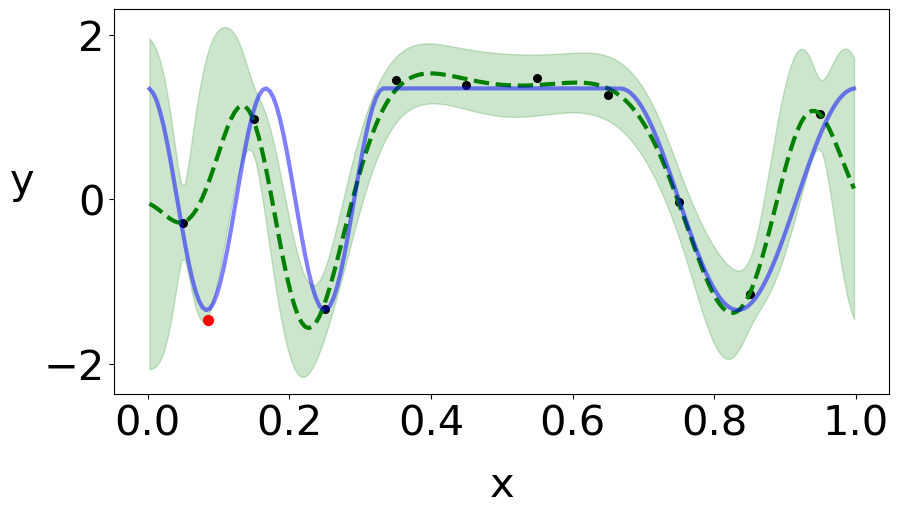


--- Round 1 ---
{'lengthscale': tensor([0.1884440722, 0.5097611557], device='cuda:0'), 'eta': 0.01750317553146735, 'tau²_hat': 1.0128364709132103}
Test RMSE: 0.4155


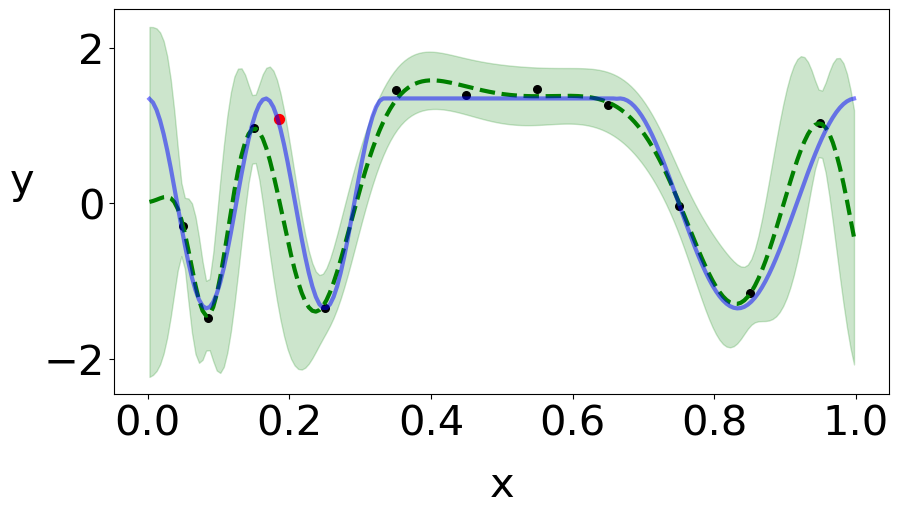


--- Round 2 ---
{'lengthscale': tensor([0.1752635378, 0.5726812480], device='cuda:0'), 'eta': 0.01837055914005341, 'tau²_hat': 1.052500062084648}
Test RMSE: 0.4362


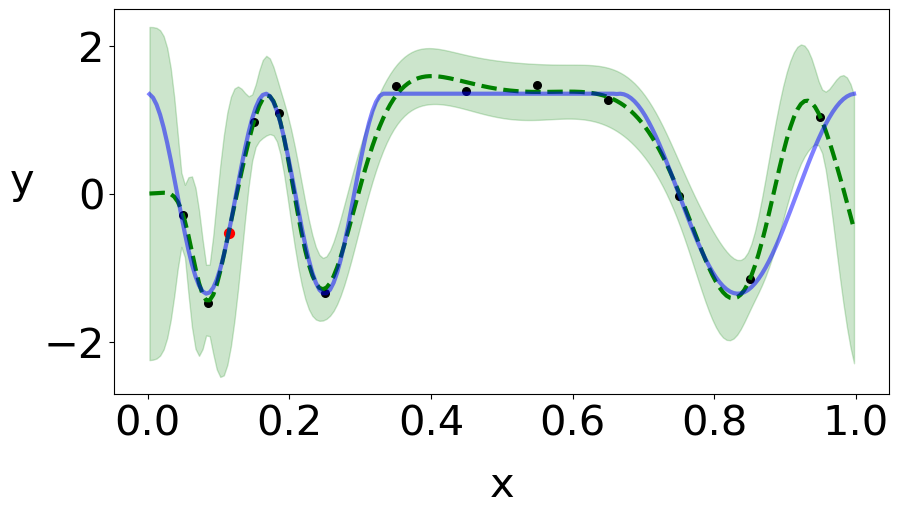


--- Round 3 ---
{'lengthscale': tensor([0.1786421350, 0.5623610170], device='cuda:0'), 'eta': 0.018344625767641655, 'tau²_hat': 1.0095107802796206}
Test RMSE: 0.4268


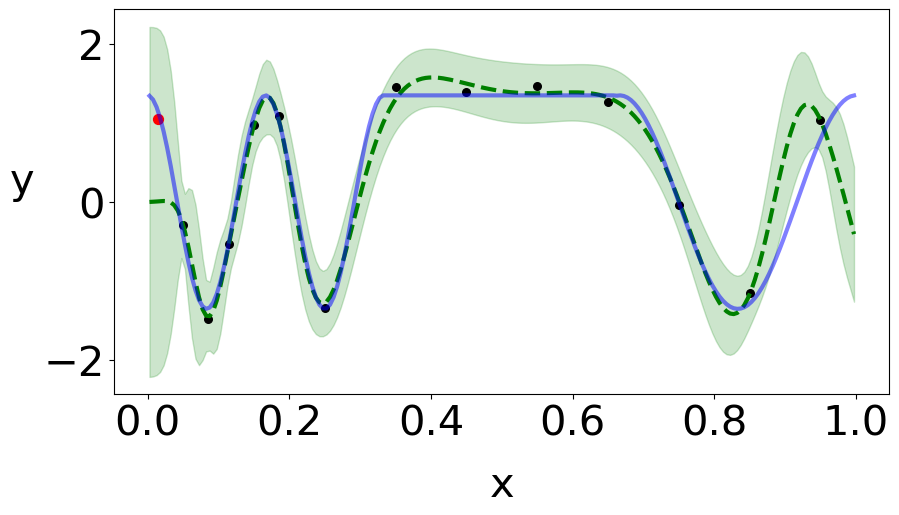


--- Round 4 ---
{'lengthscale': tensor([0.1485540821, 0.5320401362], device='cuda:0'), 'eta': 0.01851612257471872, 'tau²_hat': 1.032989560284317}
Test RMSE: 0.3763


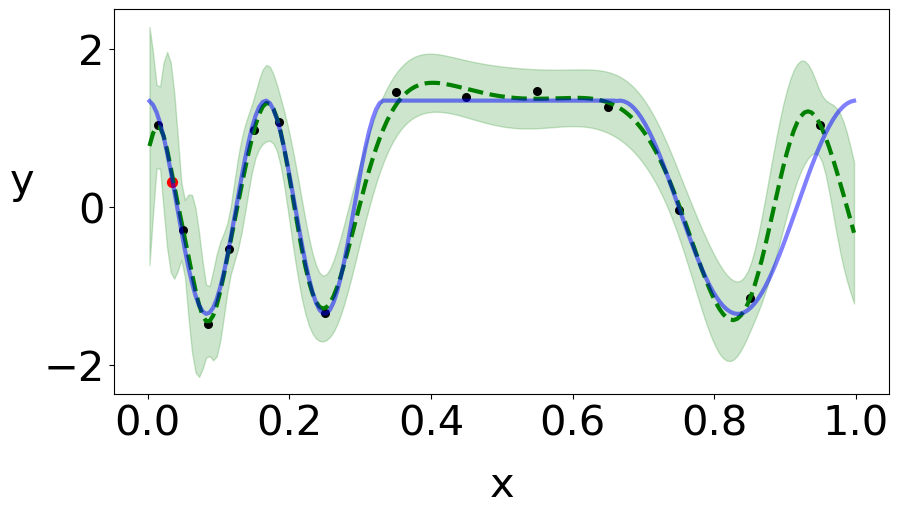


--- Round 5 ---
{'lengthscale': tensor([0.3547789640, 0.1959960215], device='cuda:0'), 'eta': 0.009593971773164048, 'tau²_hat': 1.2142423832695255}
Test RMSE: 0.3417


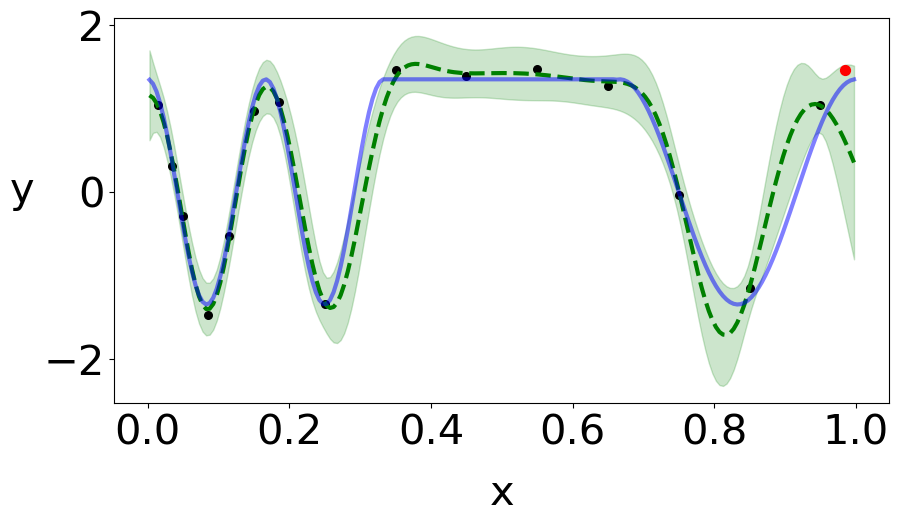


--- Round 6 ---
{'lengthscale': tensor([0.3427548477, 0.1795888072], device='cuda:0'), 'eta': 0.0053968683195105, 'tau²_hat': 1.1373877030010906}
Test RMSE: 0.2640


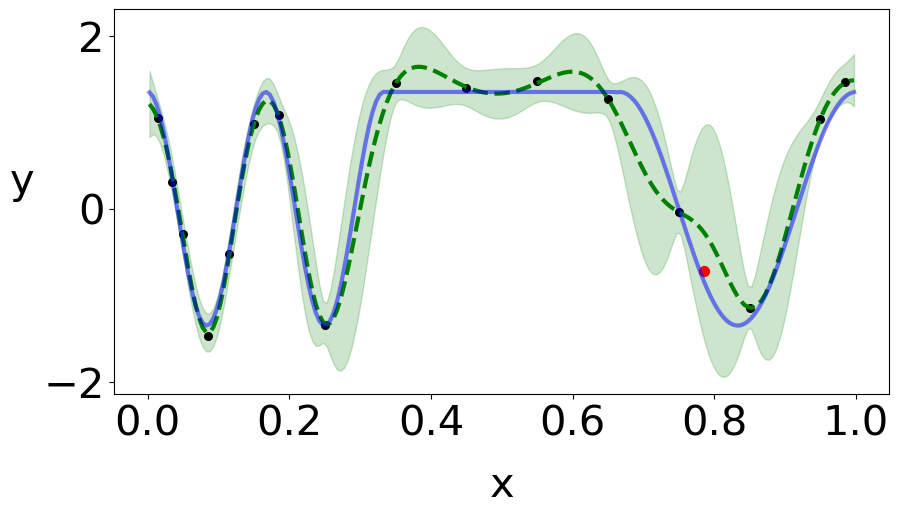


--- Round 7 ---
{'lengthscale': tensor([0.2654525196, 0.2919221227], device='cuda:0'), 'eta': 0.018581899408943166, 'tau²_hat': 1.1154520033327568}
Test RMSE: 0.1955


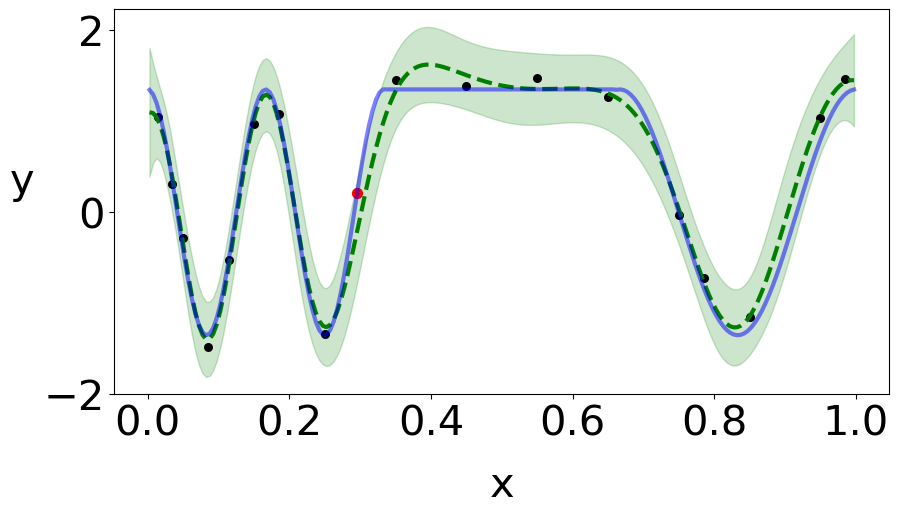


--- Round 8 ---
{'lengthscale': tensor([0.1861806447, 0.4350982419], device='cuda:0'), 'eta': 0.0052957774538859885, 'tau²_hat': 1.0084635881002166}
Test RMSE: 0.1648


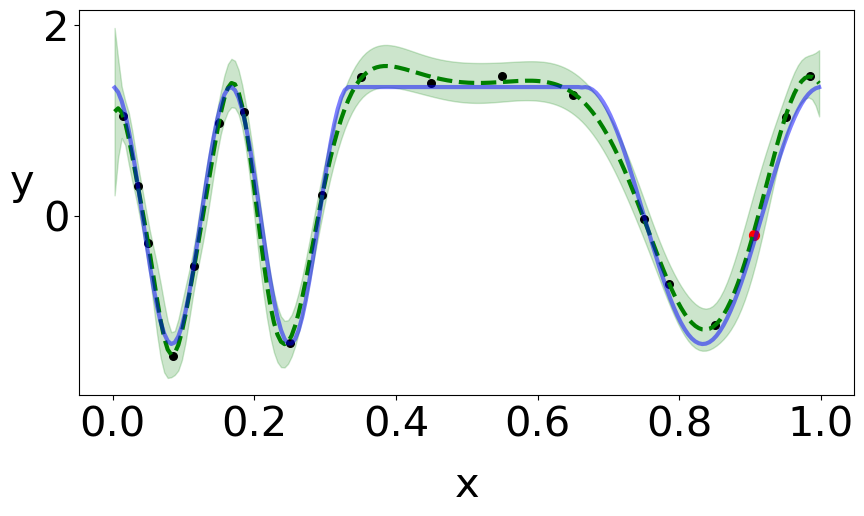


--- Round 9 ---
{'lengthscale': tensor([0.2005932127, 0.4374269535], device='cuda:0'), 'eta': 0.0034347206341316205, 'tau²_hat': 1.0519699470697776}
Test RMSE: 0.1618


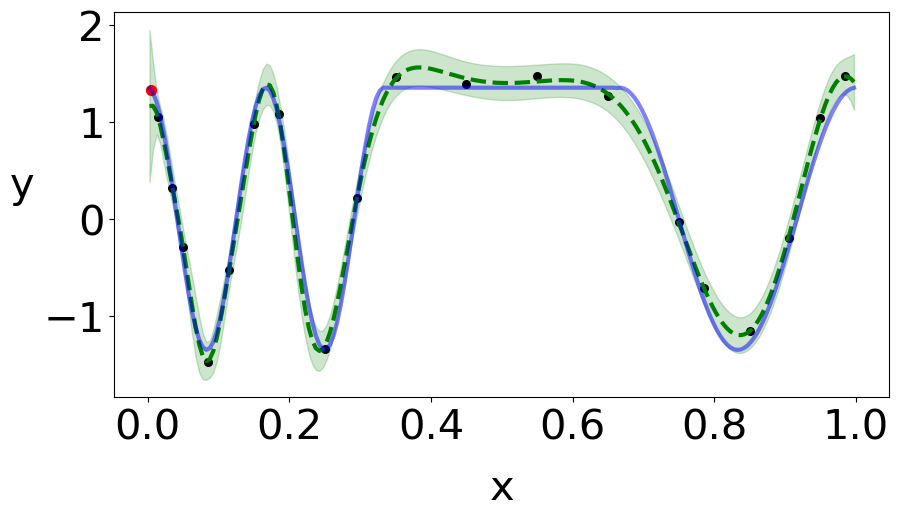


--- Round 10 ---
{'lengthscale': tensor([0.2246536523, 0.2784303014], device='cuda:0'), 'eta': 2.4619064639719077e-29, 'tau²_hat': 1.1225887855630021}
Test RMSE: 0.1463


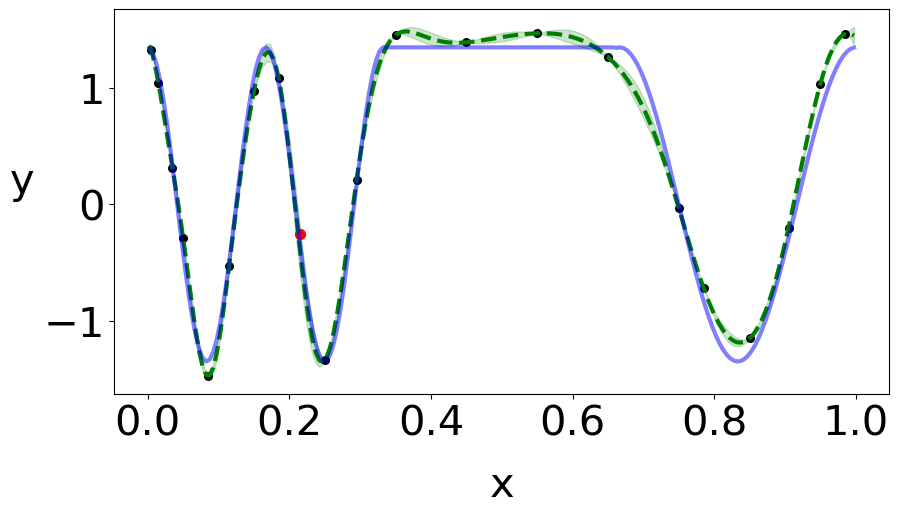


--- Round 11 ---
{'lengthscale': tensor([0.2473548196, 0.2613692047], device='cuda:0'), 'eta': 2.4619064639719077e-29, 'tau²_hat': 1.1035657315606089}
Test RMSE: 0.1449


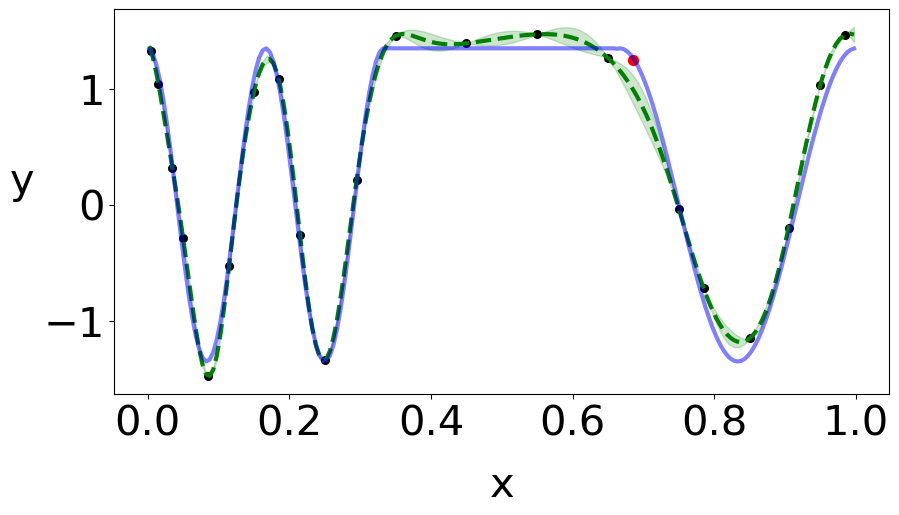


--- Round 12 ---
{'lengthscale': tensor([0.2755344474, 0.2238263960], device='cuda:0'), 'eta': 2.4619064639719077e-29, 'tau²_hat': 1.0734737176645344}
Test RMSE: 0.1375


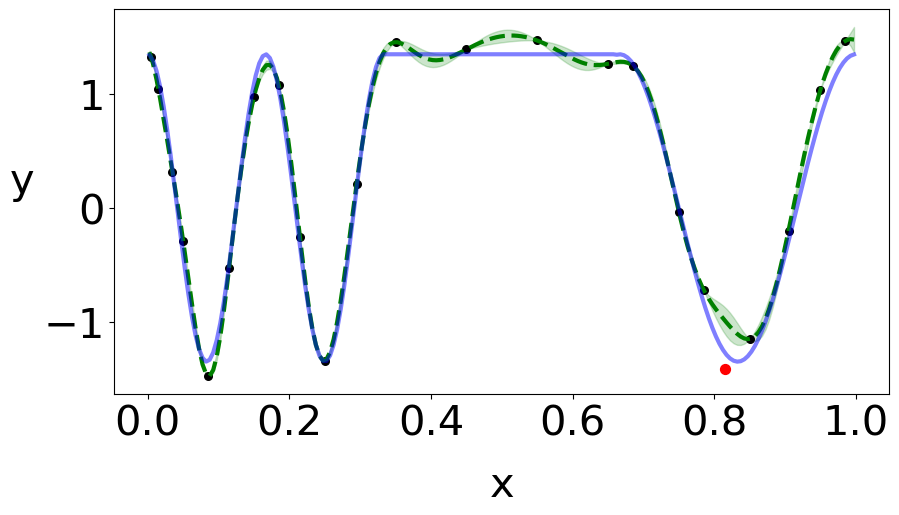


--- Round 13 ---
{'lengthscale': tensor([0.3254442148, 0.1687408061], device='cuda:0'), 'eta': 2.4619064639719077e-29, 'tau²_hat': 1.0441239257575023}
Test RMSE: 0.1668


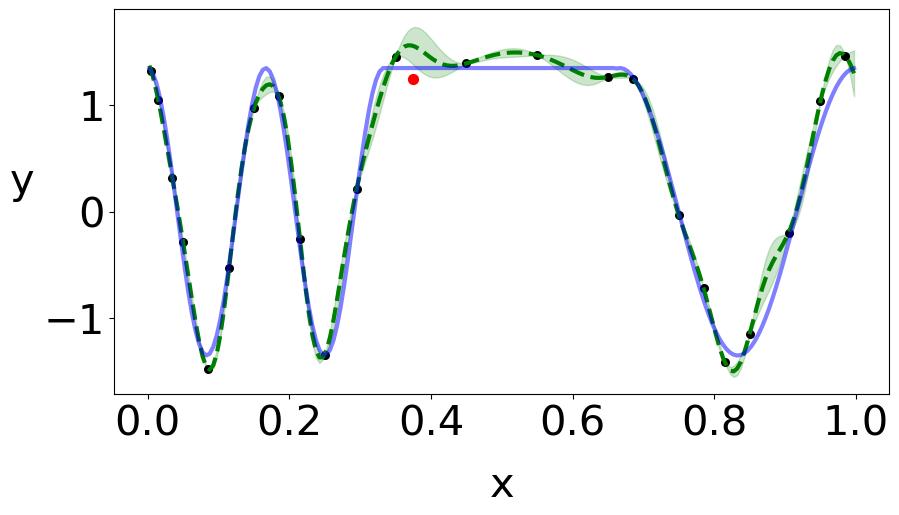


--- Round 14 ---
{'lengthscale': tensor([0.3212057759, 0.1684736537], device='cuda:0'), 'eta': 2.4619064639719077e-29, 'tau²_hat': 1.0093131447703456}
Test RMSE: 0.1464


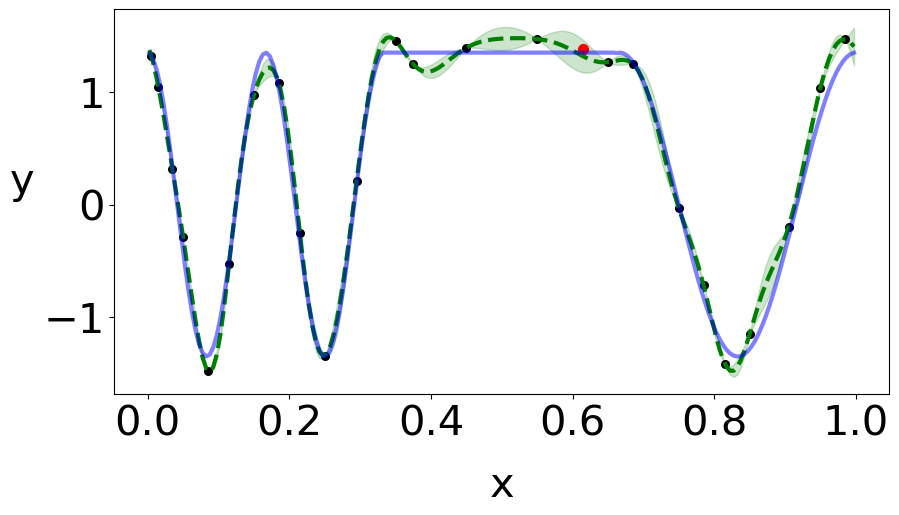


--- Round 15 ---
{'lengthscale': tensor([0.3303033035, 0.1570984634], device='cuda:0'), 'eta': 2.4619064639719077e-29, 'tau²_hat': 0.9936419561830393}
Test RMSE: 0.1543


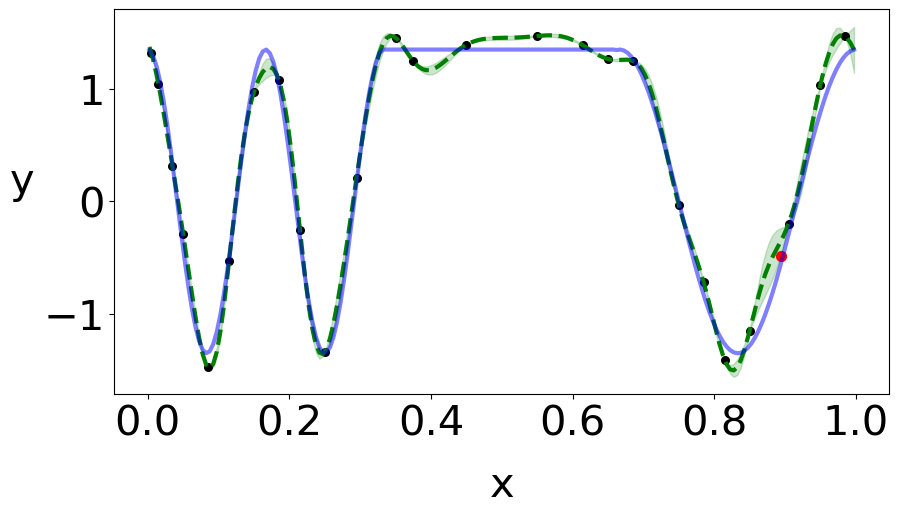


--- Round 16 ---
{'lengthscale': tensor([0.3349366047, 0.1569617905], device='cuda:0'), 'eta': 2.4619064639719077e-29, 'tau²_hat': 0.9631790910360035}
Test RMSE: 0.1416


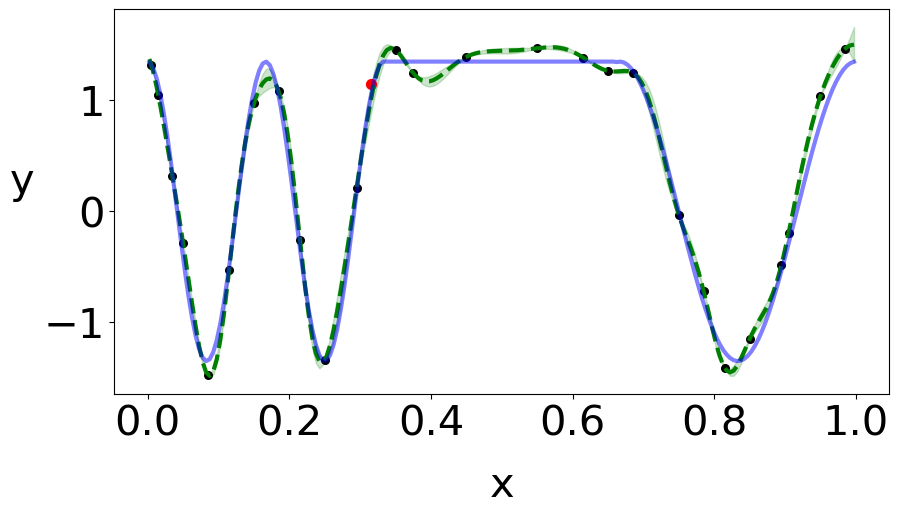


--- Round 17 ---
{'lengthscale': tensor([0.3371345903, 0.1628807696], device='cuda:0'), 'eta': 2.4619064639719077e-29, 'tau²_hat': 0.9915405707592367}
Test RMSE: 0.1382


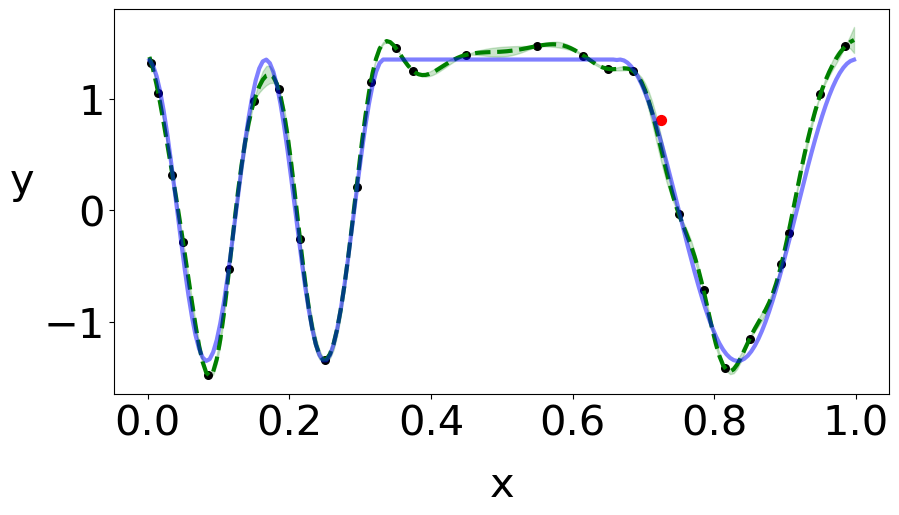


--- Round 18 ---
{'lengthscale': tensor([0.3549284410, 0.1467651147], device='cuda:0'), 'eta': 2.4619064639719077e-29, 'tau²_hat': 0.9758689805092636}
Test RMSE: 0.1443


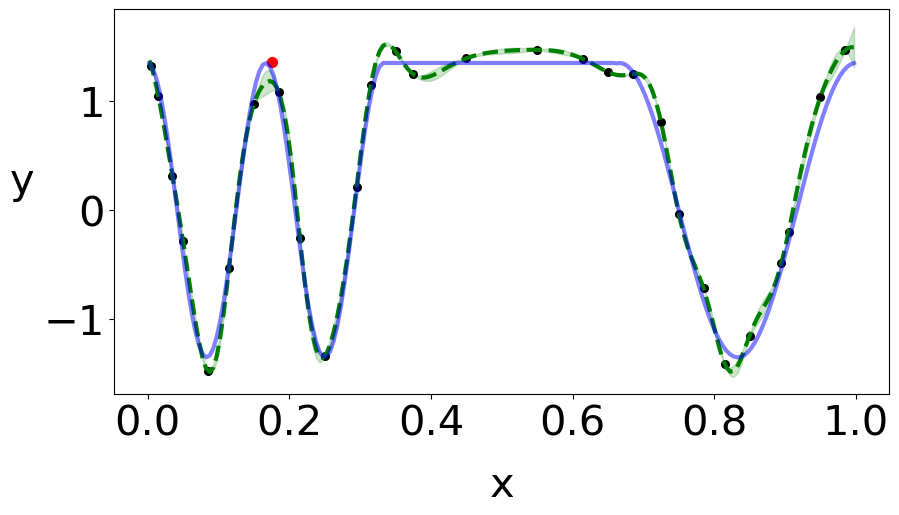


--- Round 19 ---
{'lengthscale': tensor([0.3230325216, 0.1465345461], device='cuda:0'), 'eta': 2.4619064639719077e-29, 'tau²_hat': 0.9299844320581393}
Test RMSE: 0.1414


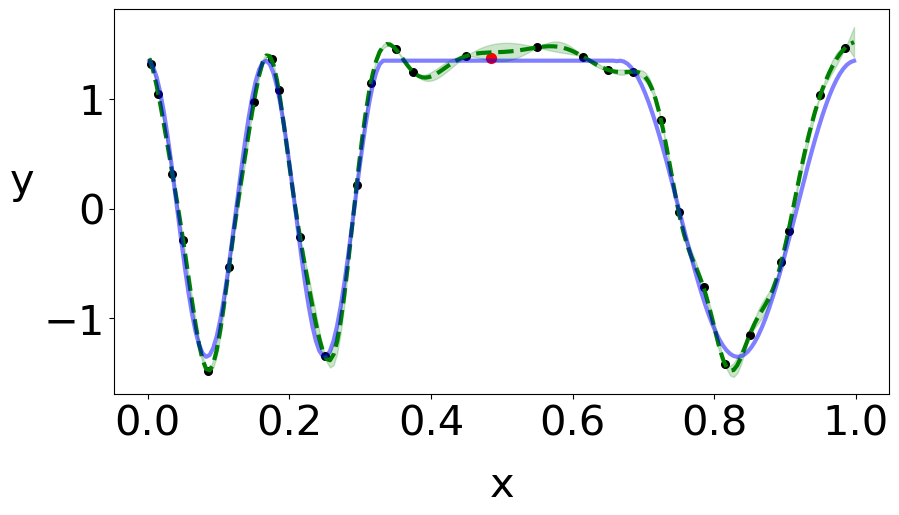

In [11]:
# === 2. 生成数据 ===
x_train, y_train, x_test, y_test, x_ref, y_ref, x_cand, y_cand = generate_dataset_for_al_gp(
    N_train=10,
    N_test=200,
    N_ref=100,
    N_cand=100,
    noise_scale=0.1,
    device=device,
    seed=None
)
np.save('data/0/ALAEmGP-toy-xtrainInitial.npy',x_train.cpu().numpy())
np.save('data/0/ALAEmGP-toy-ytrainInitial.npy',y_train.cpu().numpy())

# === 3. 初始化模型 ===
ae = Autoencoder(input_dim=1, latent_dim=2,hidden_dims=[6,]).to(device)
gp = ParametricGP(latent_dim=2).to(device)
model = JointModel(ae, gp).to(device)

import copy

ae_copy = Autoencoder(input_dim=1, latent_dim=2, hidden_dims=[6,]).to(device)
gp_copy = ParametricGP(latent_dim=2).to(device)
model_copy = JointModel(ae_copy, gp_copy).to(device)

model_copy.load_state_dict(copy.deepcopy(model.state_dict()))

# === 4. 运行主循环 ===
result = run_active_learning(
    model=model,
    x_train_init=x_train,
    y_train_init=y_train,
    x_cand=x_cand,
    y_cand=y_cand,
    x_ref=x_ref,
    x_test=x_test,
    y_test=y_test,
    T=20,
    save_plot_path="fig/0/ALAEmGP-toy",
    randomAC=False
)

np.save('data/0/ALAEmGP-toy-xtrainFinal.npy',result['final_x_train'].cpu().numpy())
np.save('data/0/ALAEmGP-toy-ytrainFinal.npy',result['final_y_train'].cpu().numpy())
np.save('data/0/ALAEmGP-toy-xtest.npy',result['x_test'].cpu().numpy())
np.save('data/0/ALAEmGP-toy-yplot.npy',result['y_plot'].cpu().numpy())
np.save('data/0/ALAEmGP-toy-testrmse.npy',result['rmse'])

final result 0.1414056408527046
first result 0.6204944676227915


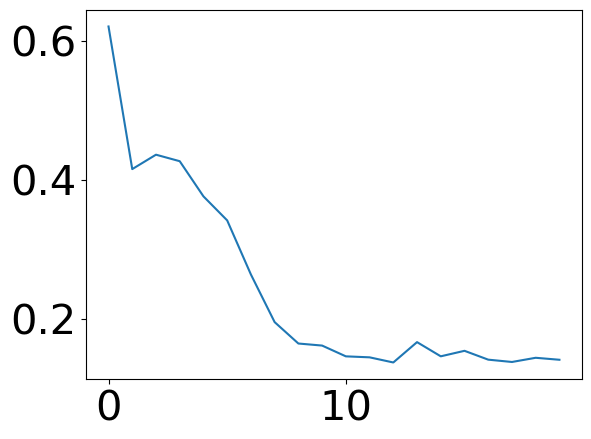

In [12]:
print('final result', result['rmse'][-1])
print('first result', result['rmse'][0])
plt.plot(result['rmse']);

In [13]:
sort_idx = x_test.squeeze().argsort()
x_test_sorted = x_test[sort_idx]
_, z_test = model.ae(x_test_sorted)
yplot_np = result['y_plot'][sort_idx].cpu().numpy()
z_test_np = z_test.detach().cpu().numpy()

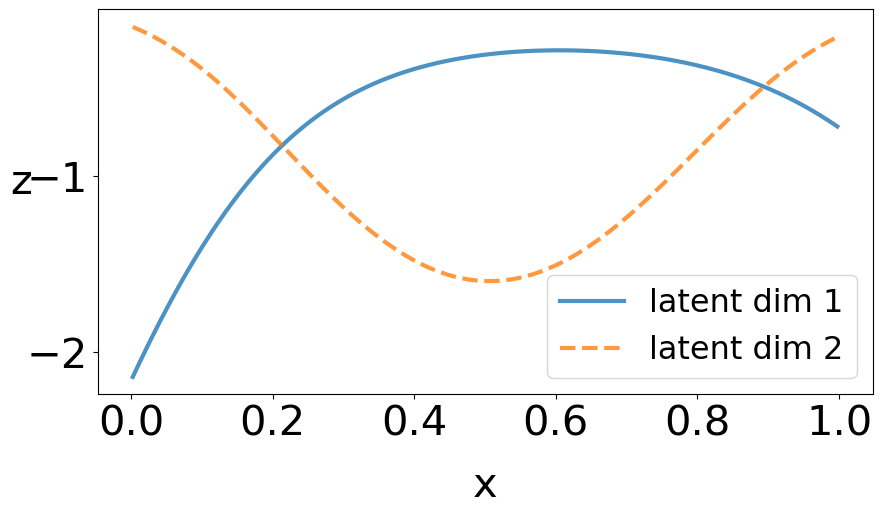

In [14]:
fig, ax = plt.subplots(1, 1,figsize=(10, 5))
ax.plot(x_test_sorted.cpu().numpy(),z_test_np[:,0],linewidth=3,label='latent dim 1', alpha=0.8);
ax.plot(x_test_sorted.cpu().numpy(),z_test_np[:,1],linewidth=3,label='latent dim 2', alpha=0.8, linestyle='--');
ax.set_xlabel('x', labelpad=15);
ax.set_ylabel('z', rotation=0);
ax.legend(loc='lower right',fontsize=23)

plt.show();


--- Round 0 ---
{'lengthscale': tensor([0.2435689039, 0.4050927568], device='cuda:0'), 'eta': 0.022037047410948425, 'tau²_hat': 0.8997326717192515}
Test RMSE: 0.6205


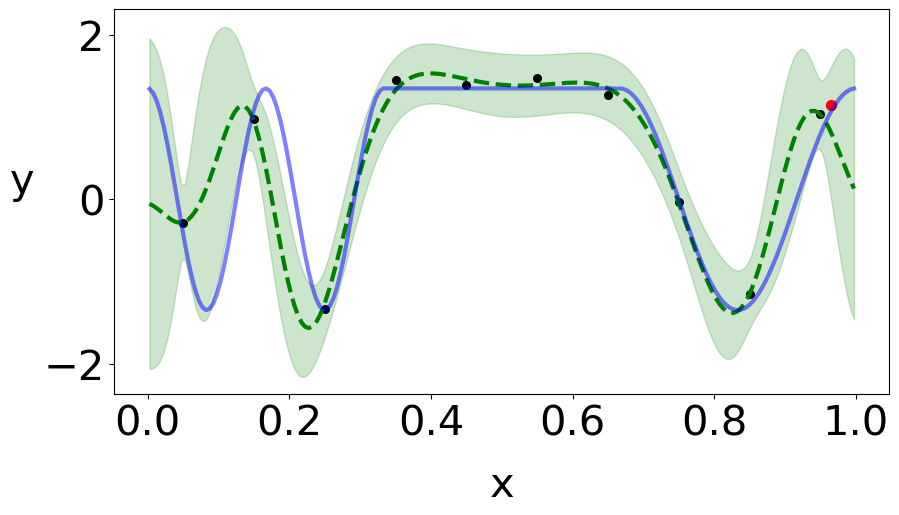


--- Round 1 ---
{'lengthscale': tensor([0.2599107098, 0.3836268697], device='cuda:0'), 'eta': 0.018482904023269436, 'tau²_hat': 0.9028171739696805}
Test RMSE: 0.6720


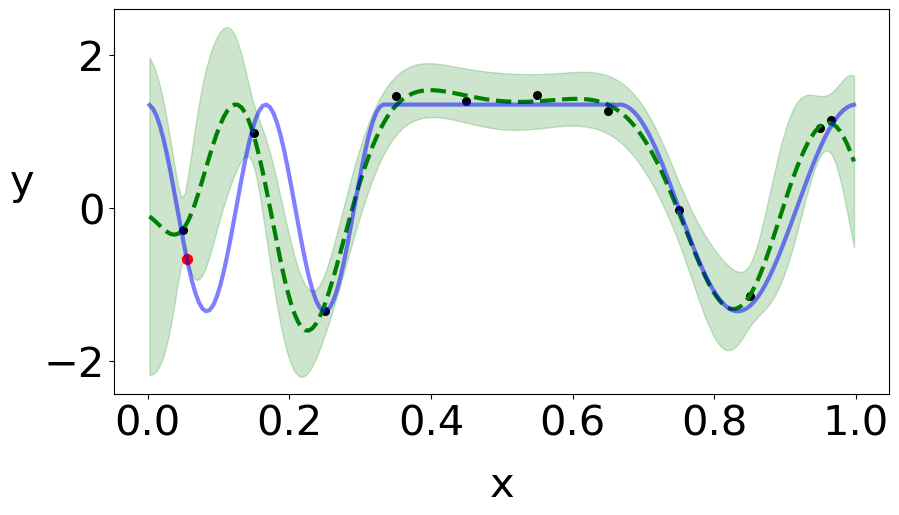


--- Round 2 ---
{'lengthscale': tensor([0.2032873951, 0.4204073279], device='cuda:0'), 'eta': 0.02291955585680279, 'tau²_hat': 0.9258023445793443}
Test RMSE: 0.4811


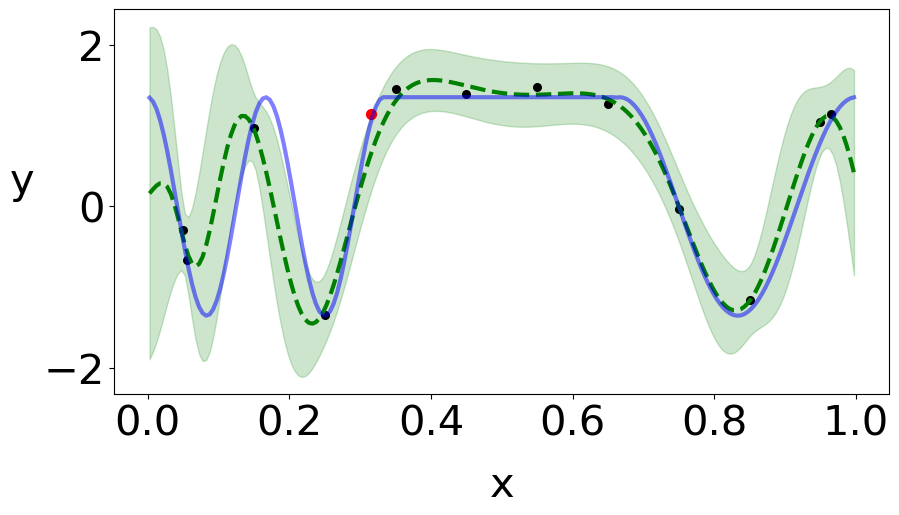


--- Round 3 ---
{'lengthscale': tensor([0.2080865645, 0.2489720118], device='cuda:0'), 'eta': 0.0006620131132781815, 'tau²_hat': 1.0809883467849097}
Test RMSE: 0.4780


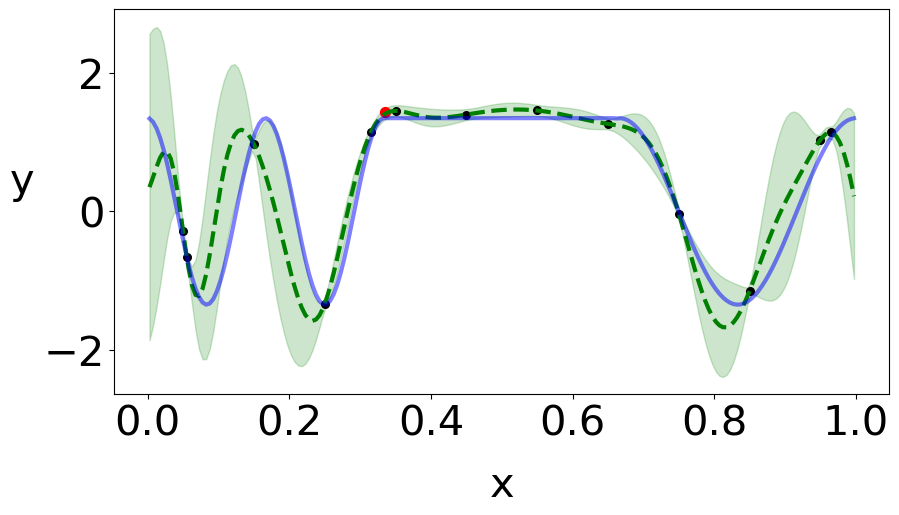


--- Round 4 ---
{'lengthscale': tensor([0.2226127055, 0.2309430514], device='cuda:0'), 'eta': 2.2167075260474477e-19, 'tau²_hat': 1.0571756893455326}
Test RMSE: 0.4669


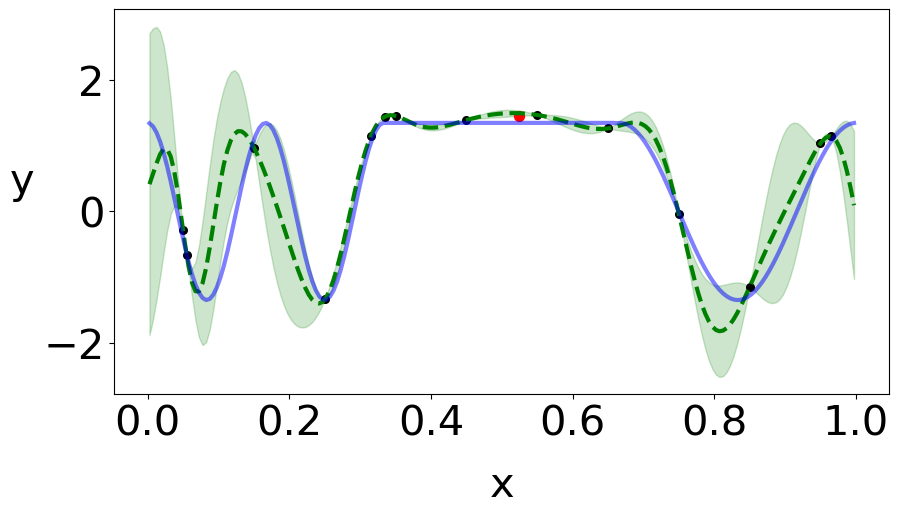


--- Round 5 ---
{'lengthscale': tensor([0.2160347845, 0.2213989598], device='cuda:0'), 'eta': 2.2167075260474477e-19, 'tau²_hat': 1.0165952890317047}
Test RMSE: 0.4262


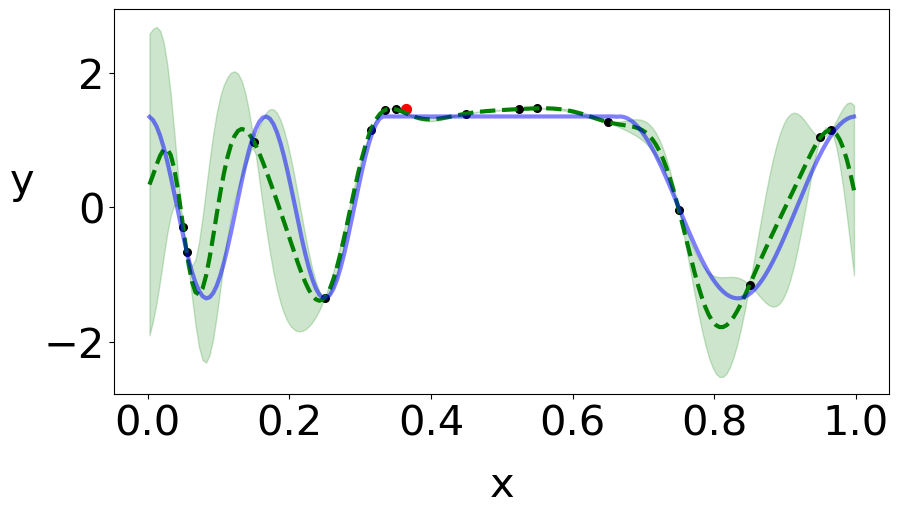


--- Round 6 ---
{'lengthscale': tensor([0.1543809947, 0.1941706822], device='cuda:0'), 'eta': 2.2167075260474477e-19, 'tau²_hat': 1.0238642732829124}
Test RMSE: 0.3575


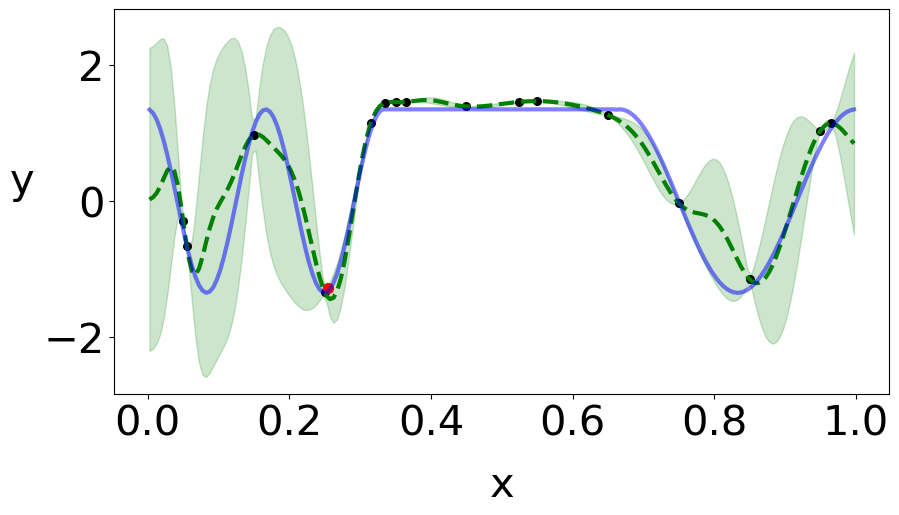


--- Round 7 ---
{'lengthscale': tensor([0.2063025786, 0.1516316916], device='cuda:0'), 'eta': 2.2167075260474477e-19, 'tau²_hat': 0.9492730180751691}
Test RMSE: 0.4143


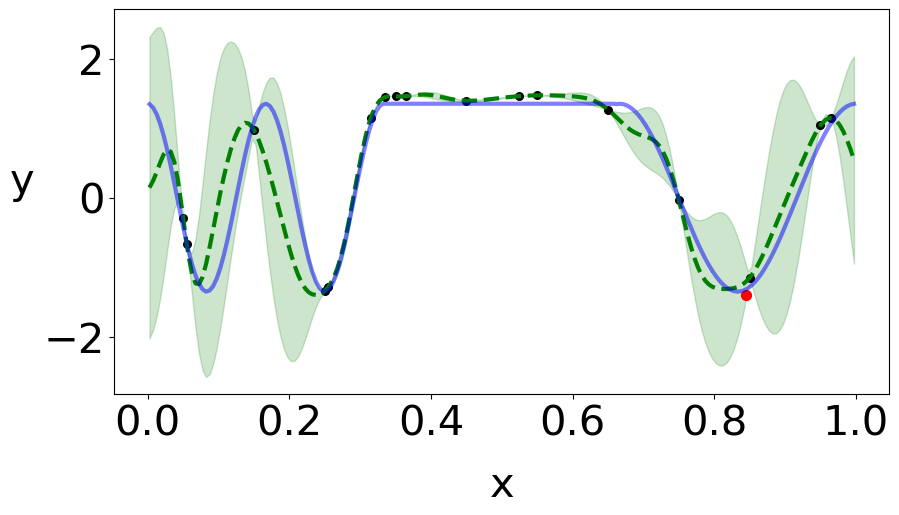


--- Round 8 ---
{'lengthscale': tensor([0.1956573906, 0.1564813123], device='cuda:0'), 'eta': 2.2167075260474477e-19, 'tau²_hat': 0.9995271794088509}
Test RMSE: 0.4849


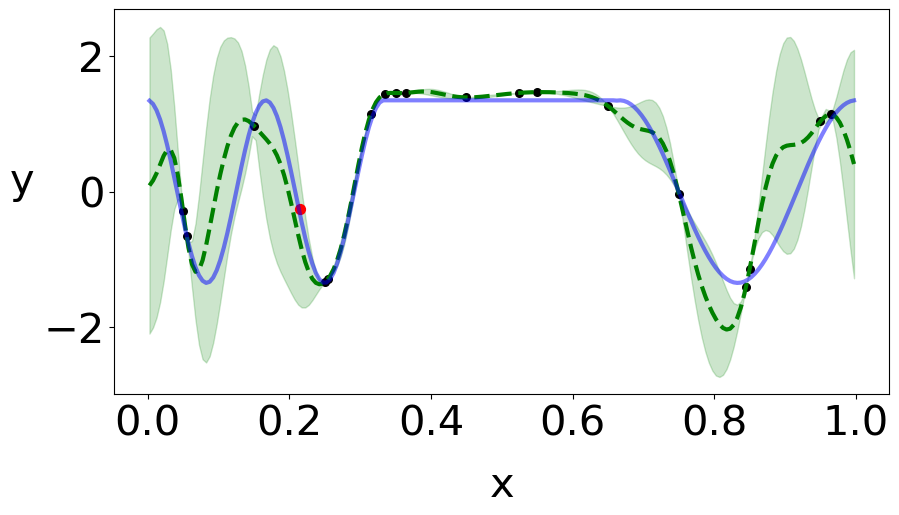


--- Round 9 ---
{'lengthscale': tensor([0.1866782658, 0.1651805158], device='cuda:0'), 'eta': 2.2167075260474477e-19, 'tau²_hat': 0.9650469615678503}
Test RMSE: 0.4625


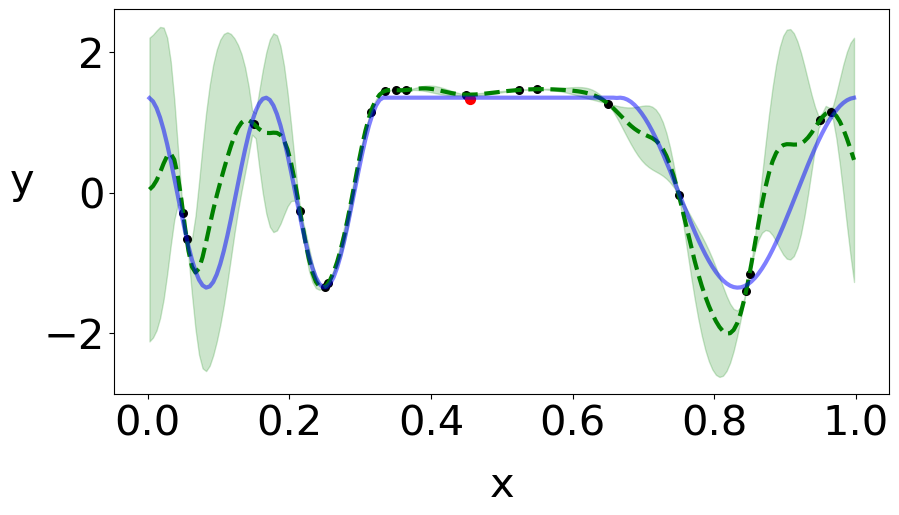


--- Round 10 ---
{'lengthscale': tensor([0.2145676014, 0.1131091699], device='cuda:0'), 'eta': 2.2167075260474477e-19, 'tau²_hat': 1.136916282768079}
Test RMSE: 0.4042


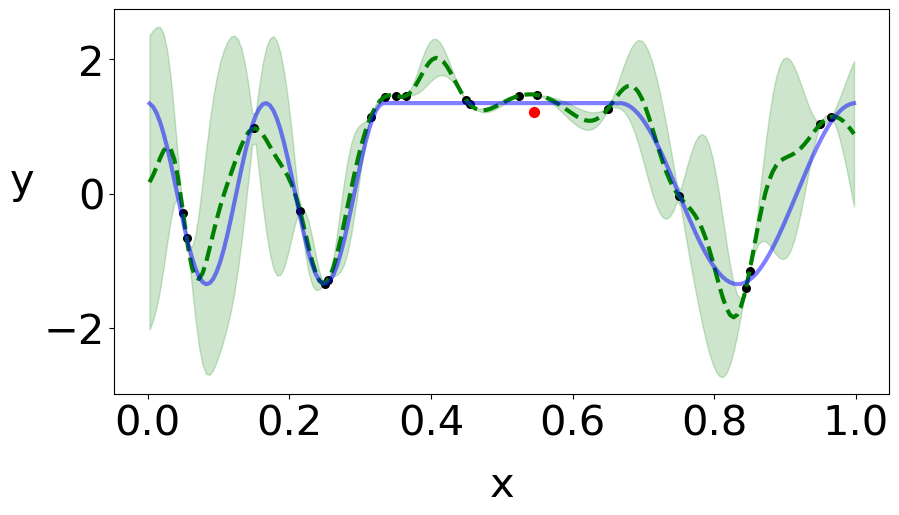


--- Round 11 ---
{'lengthscale': tensor([0.2176322169, 0.0115719568], device='cuda:0'), 'eta': 2.2167075260474477e-19, 'tau²_hat': 1.4122838199241652}
Test RMSE: 3.2694


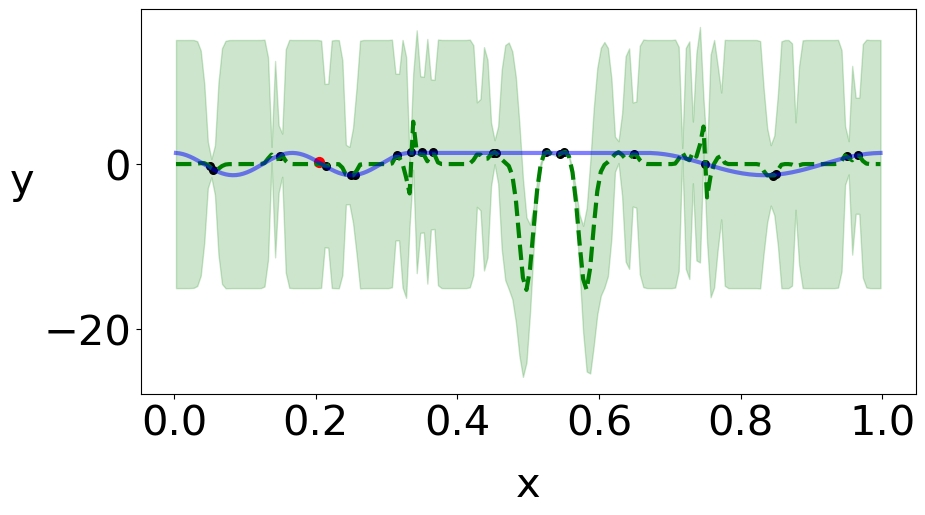


--- Round 12 ---
{'lengthscale': tensor([0.2236500866, 0.0112795938], device='cuda:0'), 'eta': 2.2167075260474477e-19, 'tau²_hat': 1.1014840492457167}
Test RMSE: 0.8920


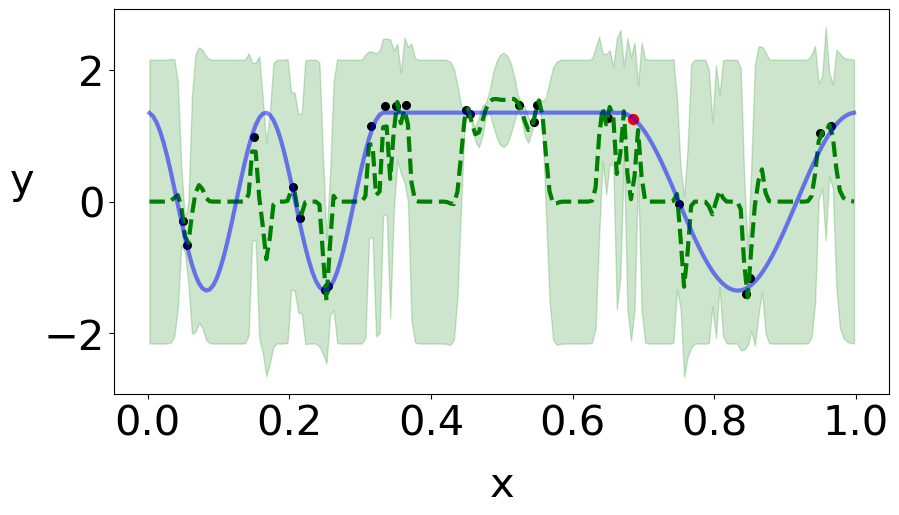


--- Round 13 ---
{'lengthscale': tensor([0.2271036614, 0.0111264557], device='cuda:0'), 'eta': 2.2167075260474477e-19, 'tau²_hat': 1.1214986494248338}
Test RMSE: 0.9256


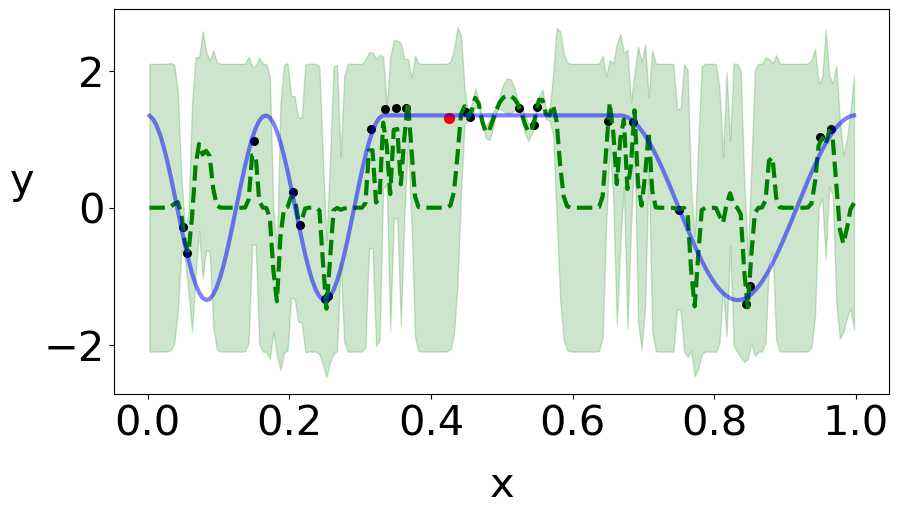


--- Round 14 ---
{'lengthscale': tensor([0.2277042327, 0.0103843712], device='cuda:0'), 'eta': 2.2167075260474477e-19, 'tau²_hat': 1.1447015735532742}
Test RMSE: 0.8910


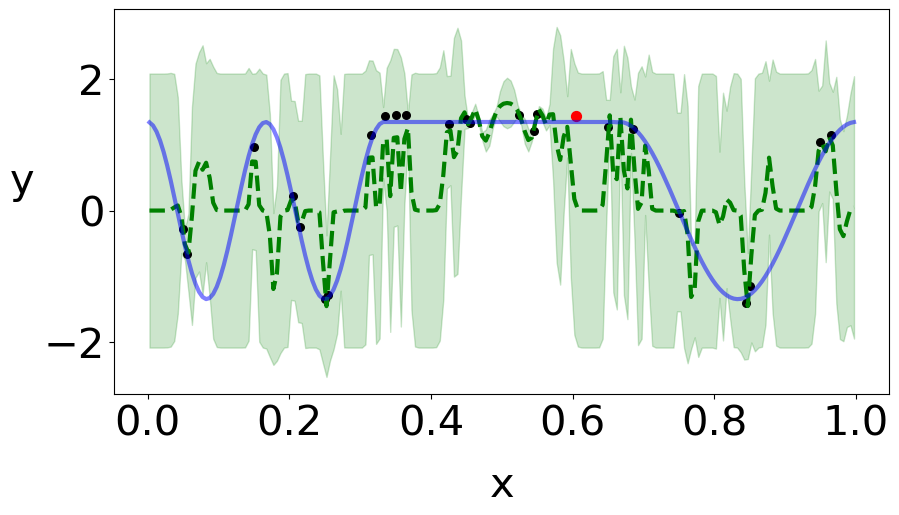


--- Round 15 ---
{'lengthscale': tensor([3.6417993114, 0.0120211453], device='cuda:0'), 'eta': 2.2167075260474477e-19, 'tau²_hat': 1.2430321482796083}
Test RMSE: 0.9039


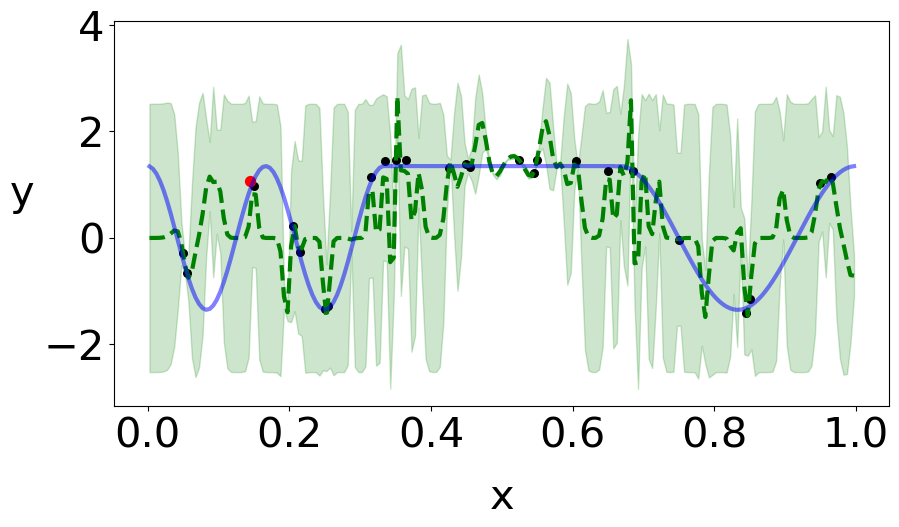


--- Round 16 ---
{'lengthscale': tensor([3.6413711769, 0.0098904305], device='cuda:0'), 'eta': 2.2167075260474477e-19, 'tau²_hat': 1.2049717174579224}
Test RMSE: 0.9100


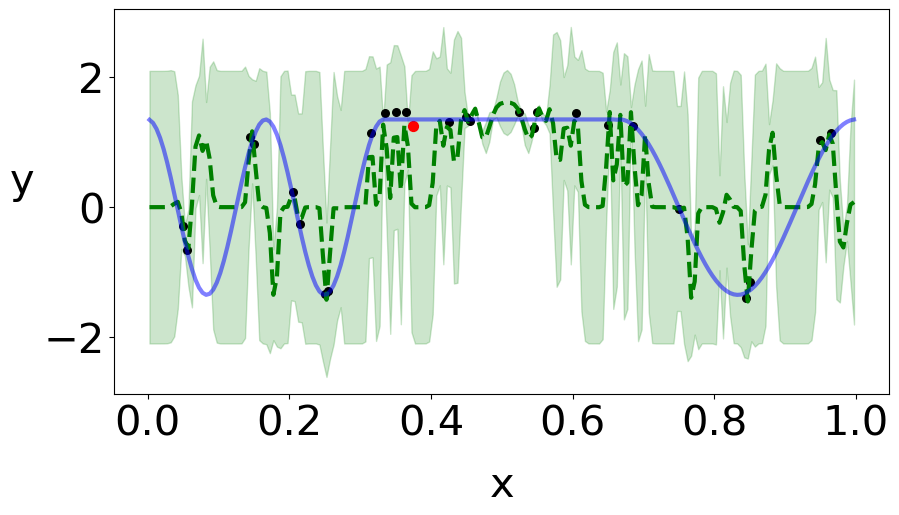


--- Round 17 ---
{'lengthscale': tensor([3.5785480704, 0.0076552057], device='cuda:0'), 'eta': 2.2167075260474477e-19, 'tau²_hat': 1.364933922021657}
Test RMSE: 0.9203


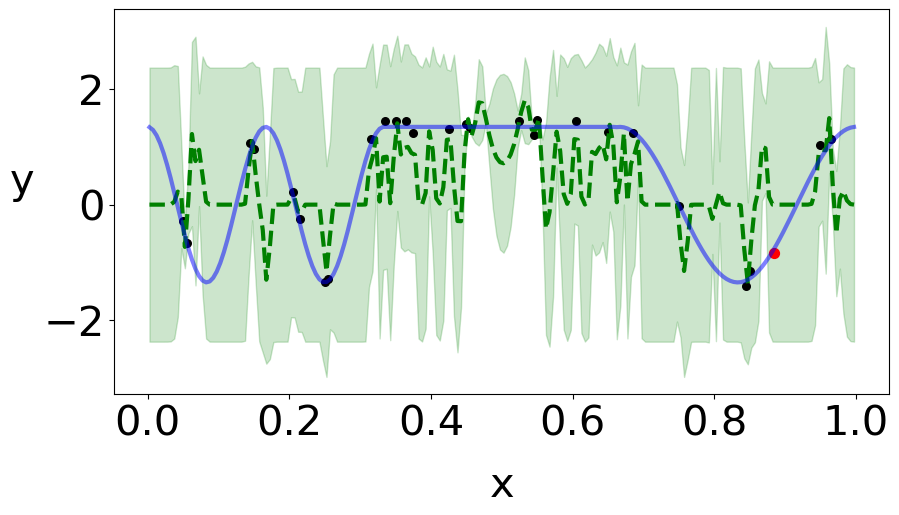


--- Round 18 ---
{'lengthscale': tensor([3.6415285843, 0.0128605279], device='cuda:0'), 'eta': 2.2167075260474477e-19, 'tau²_hat': 1.2115628324056973}
Test RMSE: 0.8816


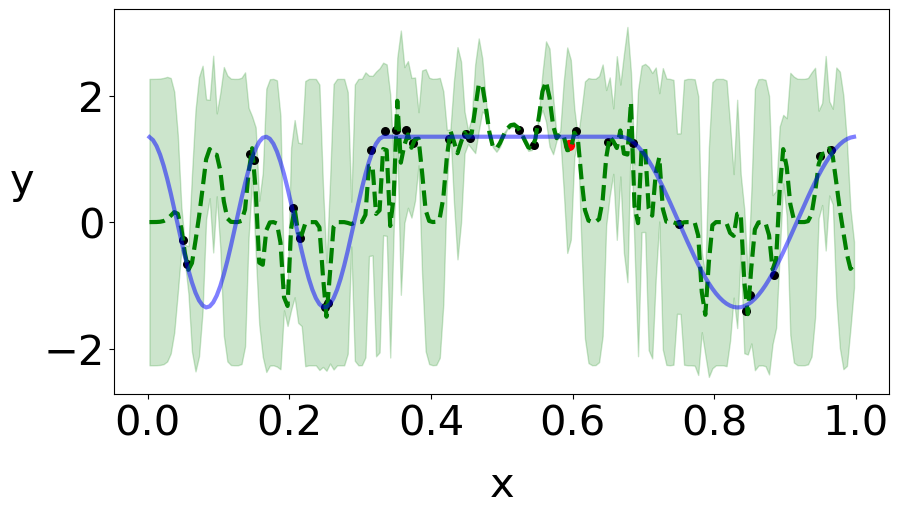


--- Round 19 ---
{'lengthscale': tensor([3.6415317117, 0.0128609607], device='cuda:0'), 'eta': 2.2167075260474477e-19, 'tau²_hat': 1.2437972839498617}
Test RMSE: 0.8648


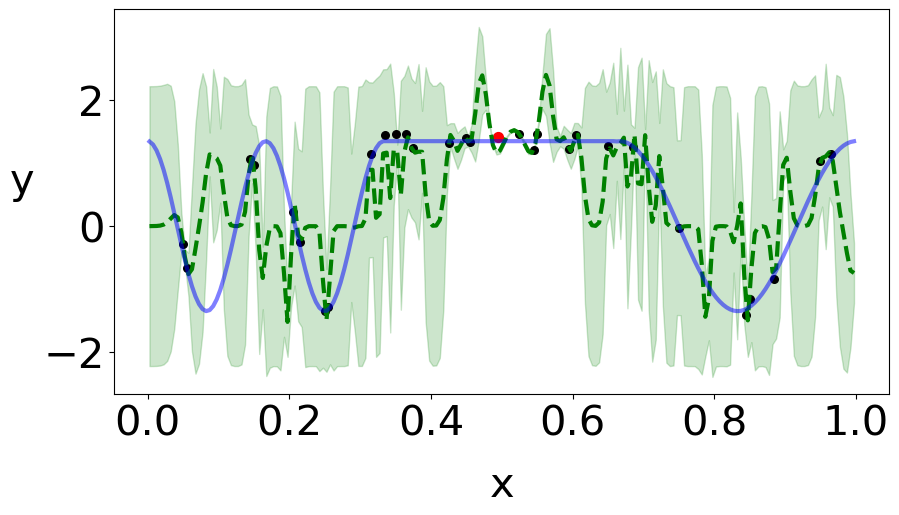

In [15]:
result_random = run_active_learning(
    model=model_copy,
    x_train_init=x_train,
    y_train_init=y_train,
    x_cand=x_cand,
    y_cand=y_cand,
    x_ref=x_ref,
    x_test=x_test,
    y_test=y_test,
    T=20,
    save_plot_path="fig/0/rALAEmGP-toy",
    randomAC=True
)
np.save('data/0/rALAEmGP-toy-xtrainFinal.npy',result_random['final_x_train'].cpu().numpy())
np.save('data/0/rALAEmGP-toy-ytrainFinal.npy',result_random['final_y_train'].cpu().numpy())
np.save('data/0/rALAEmGP-toy-yplot.npy',result_random['y_plot'].cpu().numpy())
np.save('data/0/rALAEmGP-toy-testrmse.npy',result_random['rmse'])

final result 0.8647641784926389
first result 0.6204944676227915


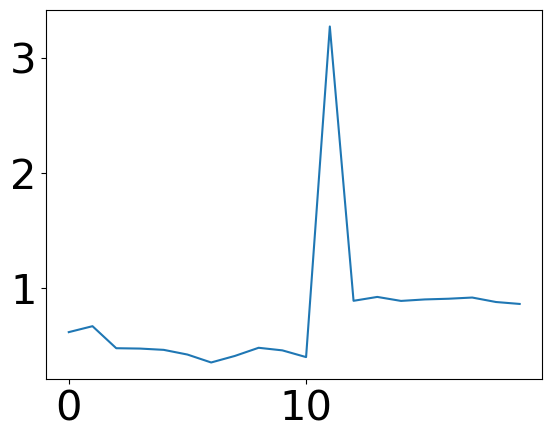

In [16]:
print('final result', result_random['rmse'][-1])
print('first result', result_random['rmse'][0])
plt.plot(result_random['rmse']);